# NLP with disaster tweets

This notebook is based on the Kaggle competition "Real or Not? NLP with Disaster Tweets" (https://www.kaggle.com/c/nlp-getting-started). We'll use the test labels only to evaluate our model in the end.  

First we import some standard packages and have a look at the data.

In [170]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [171]:
train = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv("test.csv", index_col='id')

In [172]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The training data seems roughly balanced with a preference for harmless tweets.

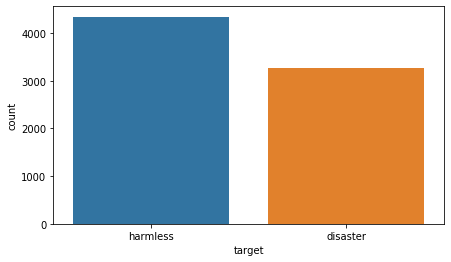

In [173]:
plt.figure(figsize=(7,4))
sns.countplot(x=train.target)
plt.xticks([0,1], ['harmless', 'disaster']);

Let's check for null entries:

In [174]:
for df, name in [(train, 'training'),  (test, 'test')]:
    for col in df.columns:
        p = round(100*df[col][df[col].isna()].shape[0]/df.shape[0],2)
        print('{}% in the column "{}" of the {} data are null entries.'.format(p, col, name))

0.8% in the column "keyword" of the training data are null entries.
33.27% in the column "location" of the training data are null entries.
0.0% in the column "text" of the training data are null entries.
0.0% in the column "target" of the training data are null entries.
0.8% in the column "keyword" of the test data are null entries.
33.86% in the column "location" of the test data are null entries.
0.0% in the column "text" of the test data are null entries.
0.0% in the column "target" of the test data are null entries.


About one third of location column has null entries. 

We suppose that the "text" column contains the most relevant information. However, we can also make use of the other columns by simply adding keyword and location to the tweet text. Later we transform these extended texts into word vectors.  

To preprocess the text data, we do the following:
- add keyword and location the text
- remove url text by dropping all expressions that start with 'http'
- replace '%20' by whitespace and '&amp' by 'and'
- drop all digits and punctuation characters. 
- remove stopwords
- apply a stemmer to identify word with the same root (i.e. "fire" and "fires"). A commonly used stemming algorithm is the Porter stemmer.

All of the above is done by the function clean(data). After cleaning, a few tweets will become identical, so we drop duplicates from the training data. 

In [175]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords = stopwords.words('english')
ps = PorterStemmer()

def clean(data):
    df=data.copy()
    #fill null entries with empty strings
    df['keyword'].fillna('', inplace=True)
    df['location'].fillna('', inplace=True)
    #add keyword and location columns to the text string
    df['text'] = df['keyword'] + ' ' + df['location'] + ' ' + df['text']
    #replace url texts and other strings
    df['text'] = df['text'].str.replace(r'http\S+', ' ')
    df['text'] = df['text'].str.replace('%20', ' ')
    df['text'] = df['text'].str.replace('&amp', ' and ')
    #remove digits and punctuation
    df['text'] = df['text'].str.replace(r'[^a-zA-Z]', ' ')
    #convert everything to lowercase
    df['text'] = df['text'].str.lower()
    #remove stopwords
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
    #stem
    df['text'] = df['text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
    return df

df=clean(train)
df = df.drop_duplicates(subset='text')
X = df['text']
y = df['target']

X_test = clean(test)['text']
y_test = test['target']

Now the tweets look like this: 

In [176]:
df.drop(['keyword', 'location', 'target'], axis=1).head(10)

,text
id,
1,deed reason earthquak may allah forgiv us
4,forest fire near la rong sask canada
5,resid ask shelter place notifi offic evacu she...
6,peopl receiv wildfir evacu order california
7,got sent photo rubi alaska smoke wildfir pour ...
8,rockyfir updat california hwi close direct due...
10,flood disast heavi rain caus flash flood stree...
13,top hill see fire wood
14,emerg evacu happen build across street


To get some overview over the tweet text, we keep track of word appearances. For this, we count how often a (stemmed) word occurs in a harmless or disaster tweet and store the count in a new dataframe. 



In [177]:
from collections import defaultdict

freq_dict_0 = defaultdict(int)
for row in df['text'][df['target']==0]:
    for word in row.split():
        freq_dict_0[word]+=1
        
freq_dict_1 = defaultdict(int)
for row in df['text'][df['target']==1]:
    for word in row.split():
        freq_dict_1[word]+=1
        
vocabulary = set(freq_dict_0.keys()).union(set(freq_dict_1.keys()))

wordcount = pd.DataFrame(list(vocabulary), columns= ["word"])
wordcount['disaster'] = wordcount['word'].apply(lambda x: freq_dict_1[x])
wordcount['harmless'] = wordcount['word'].apply(lambda x: freq_dict_0[x])
wordcount['total_count'] = wordcount['disaster']+wordcount['harmless']
wordcount.sort_values(by='total_count', ascending=False, inplace=True)
wordcount.set_index('word', inplace=True)


In [178]:
wordcount

,disaster,harmless,total_count
word,,,
fire,416,146,562
like,102,308,410
new,133,256,389
bomb,279,96,375
burn,148,171,319
...,...,...,...
edw,0,1,1
prayforsaipan,1,0,1
chicope,0,1,1


Let's see what the most frequent words in harmless vs. disaster tweets are.

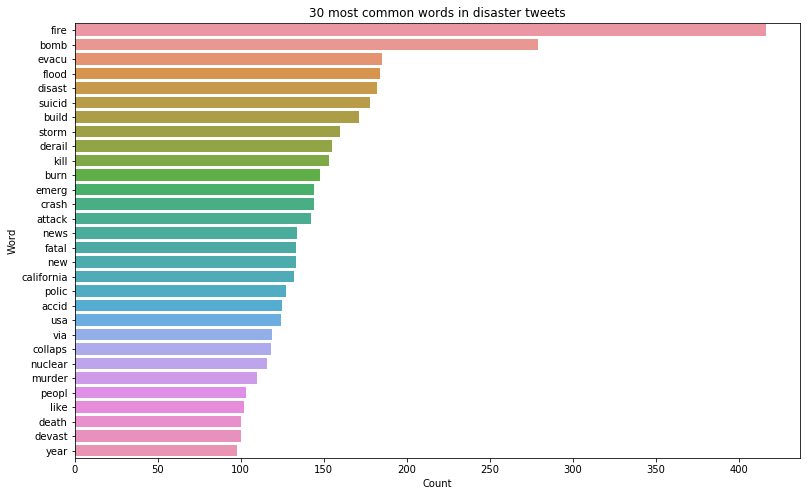

In [179]:
plt.figure(figsize=(13,8))
sns.barplot(x=wordcount['disaster'].sort_values(ascending=False).iloc[:30], y=wordcount.sort_values(by='disaster', ascending=False).index[:30])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('30 most common words in disaster tweets');

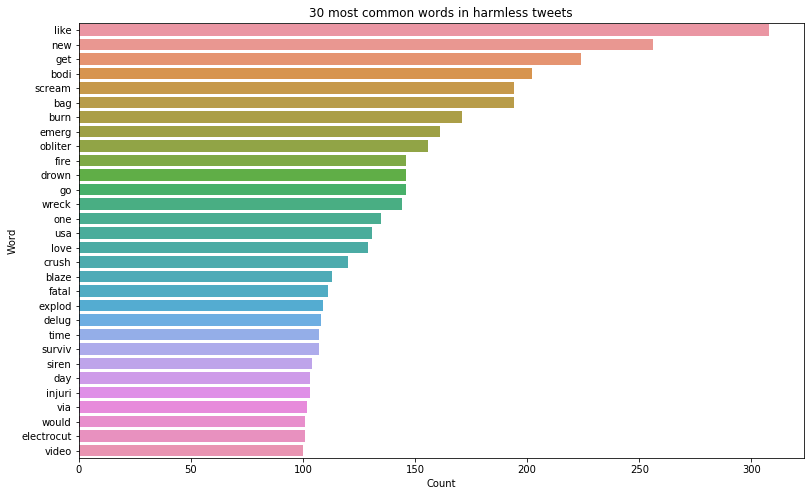

In [181]:
plt.figure(figsize=(13,8))
sns.barplot(x=wordcount['harmless'].sort_values(ascending=False).iloc[:30], y=wordcount.sort_values(by='harmless', ascending=False).index[:30])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('30 most common words in harmless tweets');

We sort out all word that occur less than five times in the training set. This significantly reduces the vocabulary. 

In [180]:
minimal_occurrences = 5

X=X.apply(lambda x: ' '.join([word for word in x.split() if wordcount['total_count'][word]>=minimal_occurrences]))
X=X[X.str.split().apply(len)>0]
y=y[X.index]
wordcount = wordcount[wordcount['total_count']>=minimal_occurrences]
new_vocabulary = set(wordcount.index)

print('Length of old vocabulary: {}'.format(len(vocabulary)))
print('Length of new vocabulary: {}'.format(len(new_vocabulary)))

Length of old vocabulary: 14617
Length of new vocabulary: 2681


Now it's time to vectorize. In this notebook, we use the count vectorizer, which encodes each tweet as a bag-of-word vector. The entry of the vector at each word is the number of occurrences of this word in the text. 

There is also a Tf-idf vectorizer, which normalizes the vector entries by the total number of tweets in which the word occurs (inverse document frequency). This reduces the influence of very frequent words on the model and seems to perform slightly better in the task at hand.

We can adjust the n-gram range to include extra dimensions for word tuples. For example, if ngram_range=(1,2), then the word vectors give occurences of the words themselves as well as pairs of words (bigrams).

In [202]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))

train_vectors = vectorizer.fit_transform(X)
test_vectors = vectorizer.transform(X_test)

train_vectors.shape

(7251, 44402)

Having vectorized the tweets, we can project the vectors down to two dimensions using singular value decomposition (SVD). 
We plot the two-dimensional projections of harmless tweets as yellow dots and of disaster tweets as red dots. Unfortunately (or expectedly), the red and yellow dots don't seem to be very well separated.  

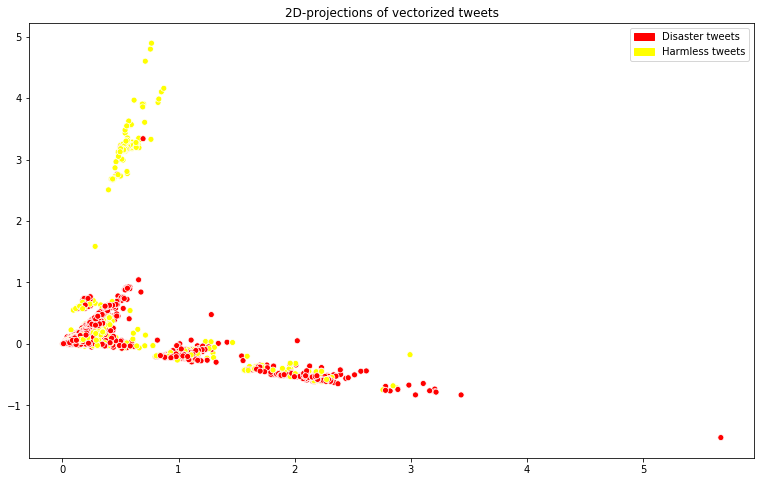

In [203]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches

plt.figure(figsize=(13,8))
svd = TruncatedSVD(n_components=2)
projected_train_vectors = svd.fit_transform(train_vectors)
sns.scatterplot(x=projected_train_vectors[:,0], y=projected_train_vectors[:,1], hue=y, palette={0:'yellow', 1:'red'}, legend=False)
red_patch = mpatches.Patch(color='red', label='Disaster tweets')
yellow_patch = mpatches.Patch(color='yellow', label='Harmless tweets')
plt.legend(handles=[red_patch, yellow_patch])
plt.title('2D-projections of vectorized tweets');

After testing several classifiers, we decide to use a stochastic gradient descent classifier for our NLP model. We do a grid search over the hyperparameters 'alpha', which is the strengh of the regularization term, and 'loss', which specifies the loss function used by the algorithm. 

The loss functions that we consider are:
- 'hinge': Corresponds to a linear SVM.
- 'log': Corresponds to logistic regression.

The performance measure used in the competition is F1-score, which is the harmonic mean of precision and recall. The precision is the percentage of samples classified as positive among all positive samples and the recall is the percentage of positive samples among all samples classified as positive. 

$$
F_1 = \frac{2}{\frac{1}{P}+\frac{1}{R}} = \frac{2\cdot\text{true positives}}{2\cdot\text{true positives} + \text{false positives} + \text{false negatives}},
$$
where 
$$
P = \frac{\text{true positives}}{\text{true positives}+\text{false positives}}, \qquad R=\frac{\text{true positives}}{\text{true positives}+\text{false negatives}}
$$

The the grid search will run a cross validation for every selection of parameters and store the classifier with the best average f1-score on the validation sets.

In [208]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer


model = SGDClassifier()

parameters = {
'loss': ['hinge', 'log'], 
'alpha': [10**e for e in range(-5,5)]
                    }
#This creates a scorer according to which the grid search will evaluate performance.
f1_scorer = make_scorer(f1_score)

#This creates a cross validation object for the grid search. Shuffling is important here, since the training data is sorted. 
cross_validation = StratifiedKFold(n_splits=5, shuffle=True)

grid_search = GridSearchCV(model, parameters, scoring=f1_scorer, verbose=0, cv=cross_validation);
grid_search.fit(train_vectors, y);


C:\Users\steff\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [209]:
print('Parameters for best SDG-classifier: {}'.format( grid_search.best_params_))
print('F1-score for best SDG-classifier in cross validation: {}%'.format(round(100*grid_search.best_score_, 2)))

Parameters for best SDG-classifier: {'alpha': 0.001, 'loss': 'log'}
F1-score for best SDG-classifier in cross validation: 74.27%


Hence we choose logistic regression with regularization parameter $\alpha=0.001$ is our model. Let's see how it performs on the test set.

In [211]:
clf = grid_search.best_estimator_
y_pred = clf.predict(test_vectors)
print('F1-score on the test set: {}%'.format(round(100*f1_score(y_test, y_pred),2)))


F1-score on the test set: 73.52%


The performance on the test set is slightly worse, but still similar. 